Kaggle competition: Dogs vs. Cats  
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition  

Loss: 0.14218%

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
import zipfile

print(tf.__version__)
print(tf.executing_eagerly())

2.3.0
True


In [ ]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')
    
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

In [ ]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)

train_files = glob('train/*.jpg')
test_files = glob('test/*.jpg')

In [ ]:
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)

def fit_generator(files, batch_size=64):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

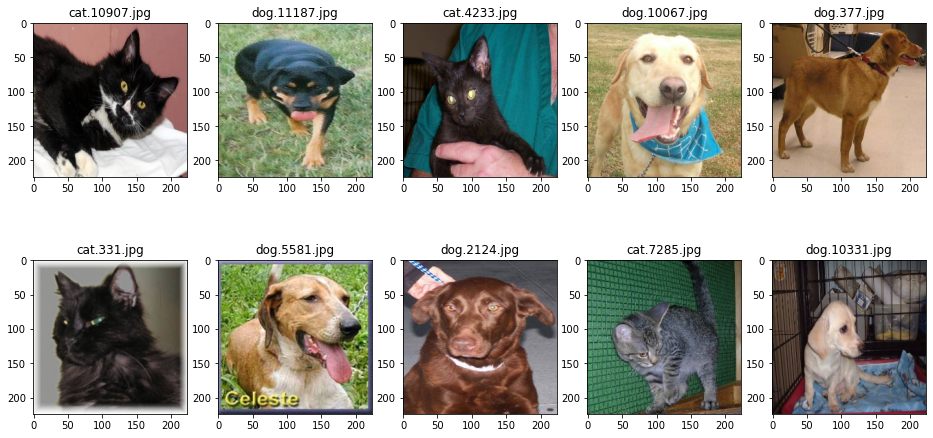

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img);

In [ ]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid',
                                kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

In [ ]:
model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-8), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

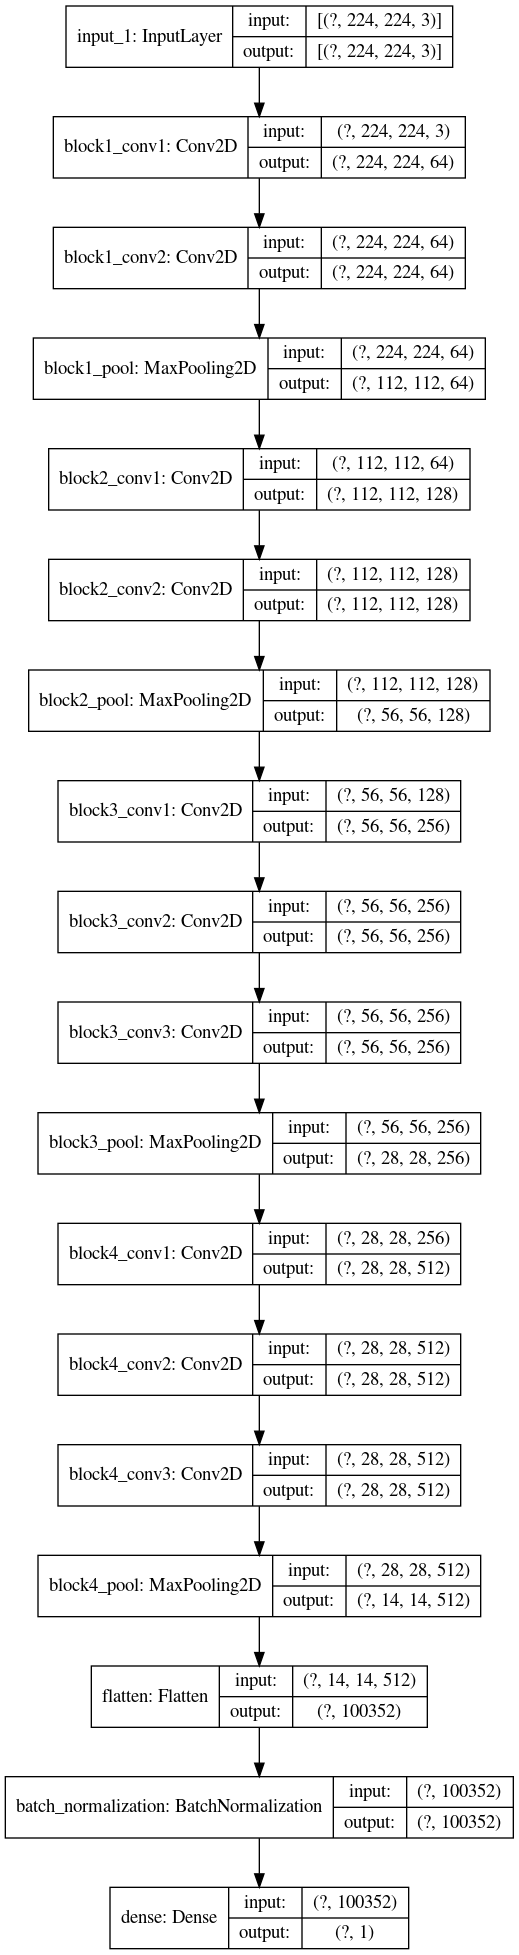

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                              monitor='val_loss',
                              patience=5,
                              min_delta=1e-7,
                              verbose=2,
                              factor=.5,
                              min_lr=1e-10,
                              mode='auto')

early_stopping = tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              min_delta=1e-7,
                              patience=5,
                              verbose=2,
                              mode='auto',
                              restore_best_weights=False)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                              'model_VGG16_custom.h5',
                              monitor='val_loss',
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=True,
                              mode='min')

In [ ]:
shuffle(train_files)
validation_data = next(fit_generator(train_files))
train_data = fit_generator(train_files)

In [ ]:
hist = model.fit(train_data,
                 batch_size=128,
                 steps_per_epoch=100,
                 epochs=100,
                 validation_data=validation_data,
                 callbacks=[model_checkpoint, reduce_lr, early_stopping])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.6579 - accuracy: 0.6817
Epoch 00001: val_loss improved from inf to 0.34642, saving model to model_VGG16_custom.h5
100/100 [==============================] - 33s 329ms/step - loss: 0.6579 - accuracy: 0.6817 - val_loss: 0.3464 - val_accuracy: 0.8750
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.4549 - accuracy: 0.8069
Epoch 00002: val_loss improved from 0.34642 to 0.26505, saving model to model_VGG16_custom.h5
100/100 [==============================] - 32s 323ms/step - loss: 0.4549 - accuracy: 0.8069 - val_loss: 0.2651 - val_accuracy: 0.9219
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8392
Epoch 00003: val_loss improved from 0.26505 to 0.23289, saving model to model_VGG16_custom.h5
100/100 [==============================] - 33s 331ms/step - loss: 0.3924 - accuracy: 0.8392 - val_loss: 0.2329 - val_accuracy: 0.9375
Epoch 4/100
100/100 [========

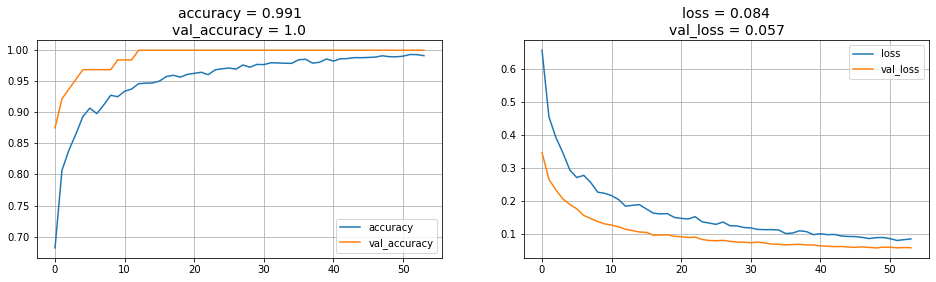

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title(('accuracy = {}\nval_accuracy = {}'.format(round(hist.history['accuracy'][-1],3), 
                                                   round(hist.history['val_accuracy'][-1],3))), fontsize=14)
plt.grid(True)
plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title(('loss = {}\nval_loss = {}'.format(round(hist.history['loss'][-1],3), 
                                           round(hist.history['val_loss'][-1],3))), fontsize=14)
plt.grid(True)
plt.show();

In [ ]:
model.load_weights('model_VGG16_custom.h5')

In [ ]:
test_pred = model.predict(predict_generator(test_files),
                          steps=len(test_files))

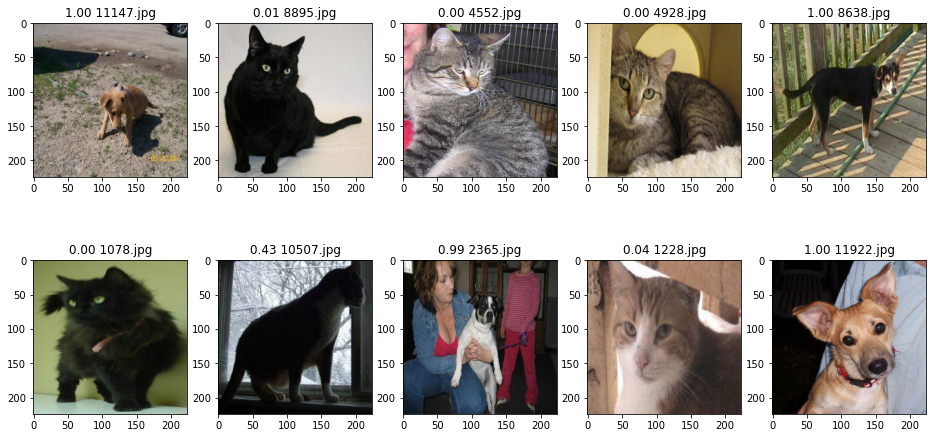

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [ ]:
import pandas as pd

submission = pd.DataFrame(columns=['id', 'label'], index=[i for i in range(len(test_pred))])

for name, score, row in zip(test_files, test_pred, range(len(test_pred))):
    submission.loc[row]['id'] = name.split('/')[1].split('.')[0]
    submission.loc[row]['label'] = float(np.round(score, decimals=5))

submission.head()

,id,label
0,11147,0.99937
1,8895,0.00801
2,4552,3e-05
3,4928,2e-05
4,8638,0.99747


In [ ]:
submission.to_csv('submission.csv', index=False)